In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter
from itertools import product

from sklearn.metrics import f1_score

from sys import path

path.append("../utils/")

from utils import get_datasets

In [36]:
#DATASETS = ["webkb", "20ng", "acm", "reut"]
#DATASETS = ["webkb"]#, "20ng", "acm", "reut"]
DATASETS = ["20ng", "acm"]

#CLFS = ["kpr", "ktr", "lpr", "ltr", "sfr", "stmk", "xfr", "xpr", "xtr", "kfr", "ktmk", "lfr", "ltmk", "spr", "str", "xlnet_softmax", "xtmk", "rep_bert"]

CLFS_SET = [
    ["bert", "normal_probas"],
    ["xlnet", "normal_probas"],
    ["ktmk", "normal_probas"],
    ["ktr", "normal_probas"],
    ["lstmk", "normal_probas"],
    ["lstr", "normal_probas"],
    ["ltr", "normal_probas"]
]

CALIB_CLFS_SET = [
    ["bert", "temperature_scaling"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "isotonic"],
    ["ktr", "isotonic"],
    ["lstmk", "isotonic"],
    ["lstr", "isotonic"],
    ["ltr", "isotonic"]
]

MIX_SET = [
    ["bert", "normal_probas"],
    ["bert", "temperature_scaling"],
    ["xlnet", "normal_probas"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "normal_probas"],
    ["ktmk", "isotonic"],
    ["lstmk", "normal_probas"],
    ["lstmk", "isotonic"],
    ["ktr", "normal_probas"],
    ["ktr", "isotonic"],
    ["lstr", "normal_probas"],
    ["lstr", "isotonic"],
    ["ltr", "normal_probas"],
    ["ltr", "isotonic"]
]

In [37]:
pd_datasets = get_datasets(DATASETS, path="/home/welton/data/pd_datasets/__dset__.csv", sep=';')

In [38]:
pd_datasets["20ng"].shape, pd_datasets["acm"].shape

((18846, 26), (24897, 26))

In [39]:
def load_probas(clf_set: list):
    d_probas = {}
    for dset in DATASETS:
        d_probas[dset] = {}
        for clf, proba_type in clf_set:
            lprobas = []
            for fold in np.arange(10):
                probs_path = f"/home/welton/data/{proba_type}/split_10/{dset}/10_folds/{clf}/{fold}/test.npz"
                lprobas.append(np.load(probs_path)["X_test"])
            d_probas[dset][clf] = np.vstack(lprobas)
    return d_probas

In [40]:
normal_probas = load_probas(CLFS_SET)

In [41]:
calib_probas = load_probas(CALIB_CLFS_SET)

In [42]:
def plot_bar(probas, hits):
    unique, counts = np.unique(probas, return_counts=True)
    confidence_count = dict(zip(unique, counts))

    y1 = []; y2 = []
    keys = list(confidence_count.keys())
    keys.sort()
    labels = []
    for key in keys:
        y1.append(confidence_count[key])
        y2.append( hits[key] if key in hits else 0 )
        upper_key = np.round(key + 0.1, decimals=1)
        labels.append(f"{key} - {upper_key}")
    x = np.arange(len(y1))

    plt.bar(x, y1, alpha=0.5, label="Confidence Counts")
    plt.bar(x, y2, alpha=0.5, label="Hits Counts")
    _ = plt.xticks(ticks=x, labels=labels, rotation=90)
    plt.legend(fontsize=14)

In [43]:
def plot_proba_dist(d_probas, pd_datasets, dataset, clf):
    predictions = d_probas[dataset][clf].argmax(axis=1)
    probas = []
    hits = {}
    df = pd_datasets[dataset]
    hits_count = 0
    # For each prediction
    for idx, predicted_class in enumerate(predictions):
        # Getting the probability of the predicted class
        probability = d_probas[dataset][clf][idx][predicted_class] * 10
        bean = np.trunc(probability) / 10
        bean = 0.9 if bean >= 1 else bean
        probas.append(bean)
        if predicted_class == df.label.values[idx]:
            if bean not in hits:
                hits[bean] = 0
            hits[bean] += 1
            hits_count += 1
    
    #print(f"{dataset.upper()} - {clf.upper()} - MaF1: {f1_score(d_labels[dataset], predictions, average='macro')} - Hits {hits_count}")
    plot_bar(probas, hits)


In [44]:
def plotter(grid_data, clfs, probas, pd_datasets):

    plt.figure(figsize=(24, 20))
    for plot_idx, (dset, clf_setting) in enumerate(product(grid_data, clfs)):
        clf, proba_type = clf_setting
        plt.subplot(4, 4, plot_idx + 1)
        #plt.subplot(3, 4, plot_idx + 1)
        if proba_type == "normal_probas":
            plot_proba_dist(probas[0], pd_datasets, dset, clf)
        else:
            plot_proba_dist(probas[1], pd_datasets, dset, clf)
        plt.title(f"{dset.upper()} - [{clf.upper()} / {proba_type.upper()}]")
        _ = plt.xticks(fontsize=14)
        _ = plt.yticks(fontsize=14)
    plt.tight_layout()

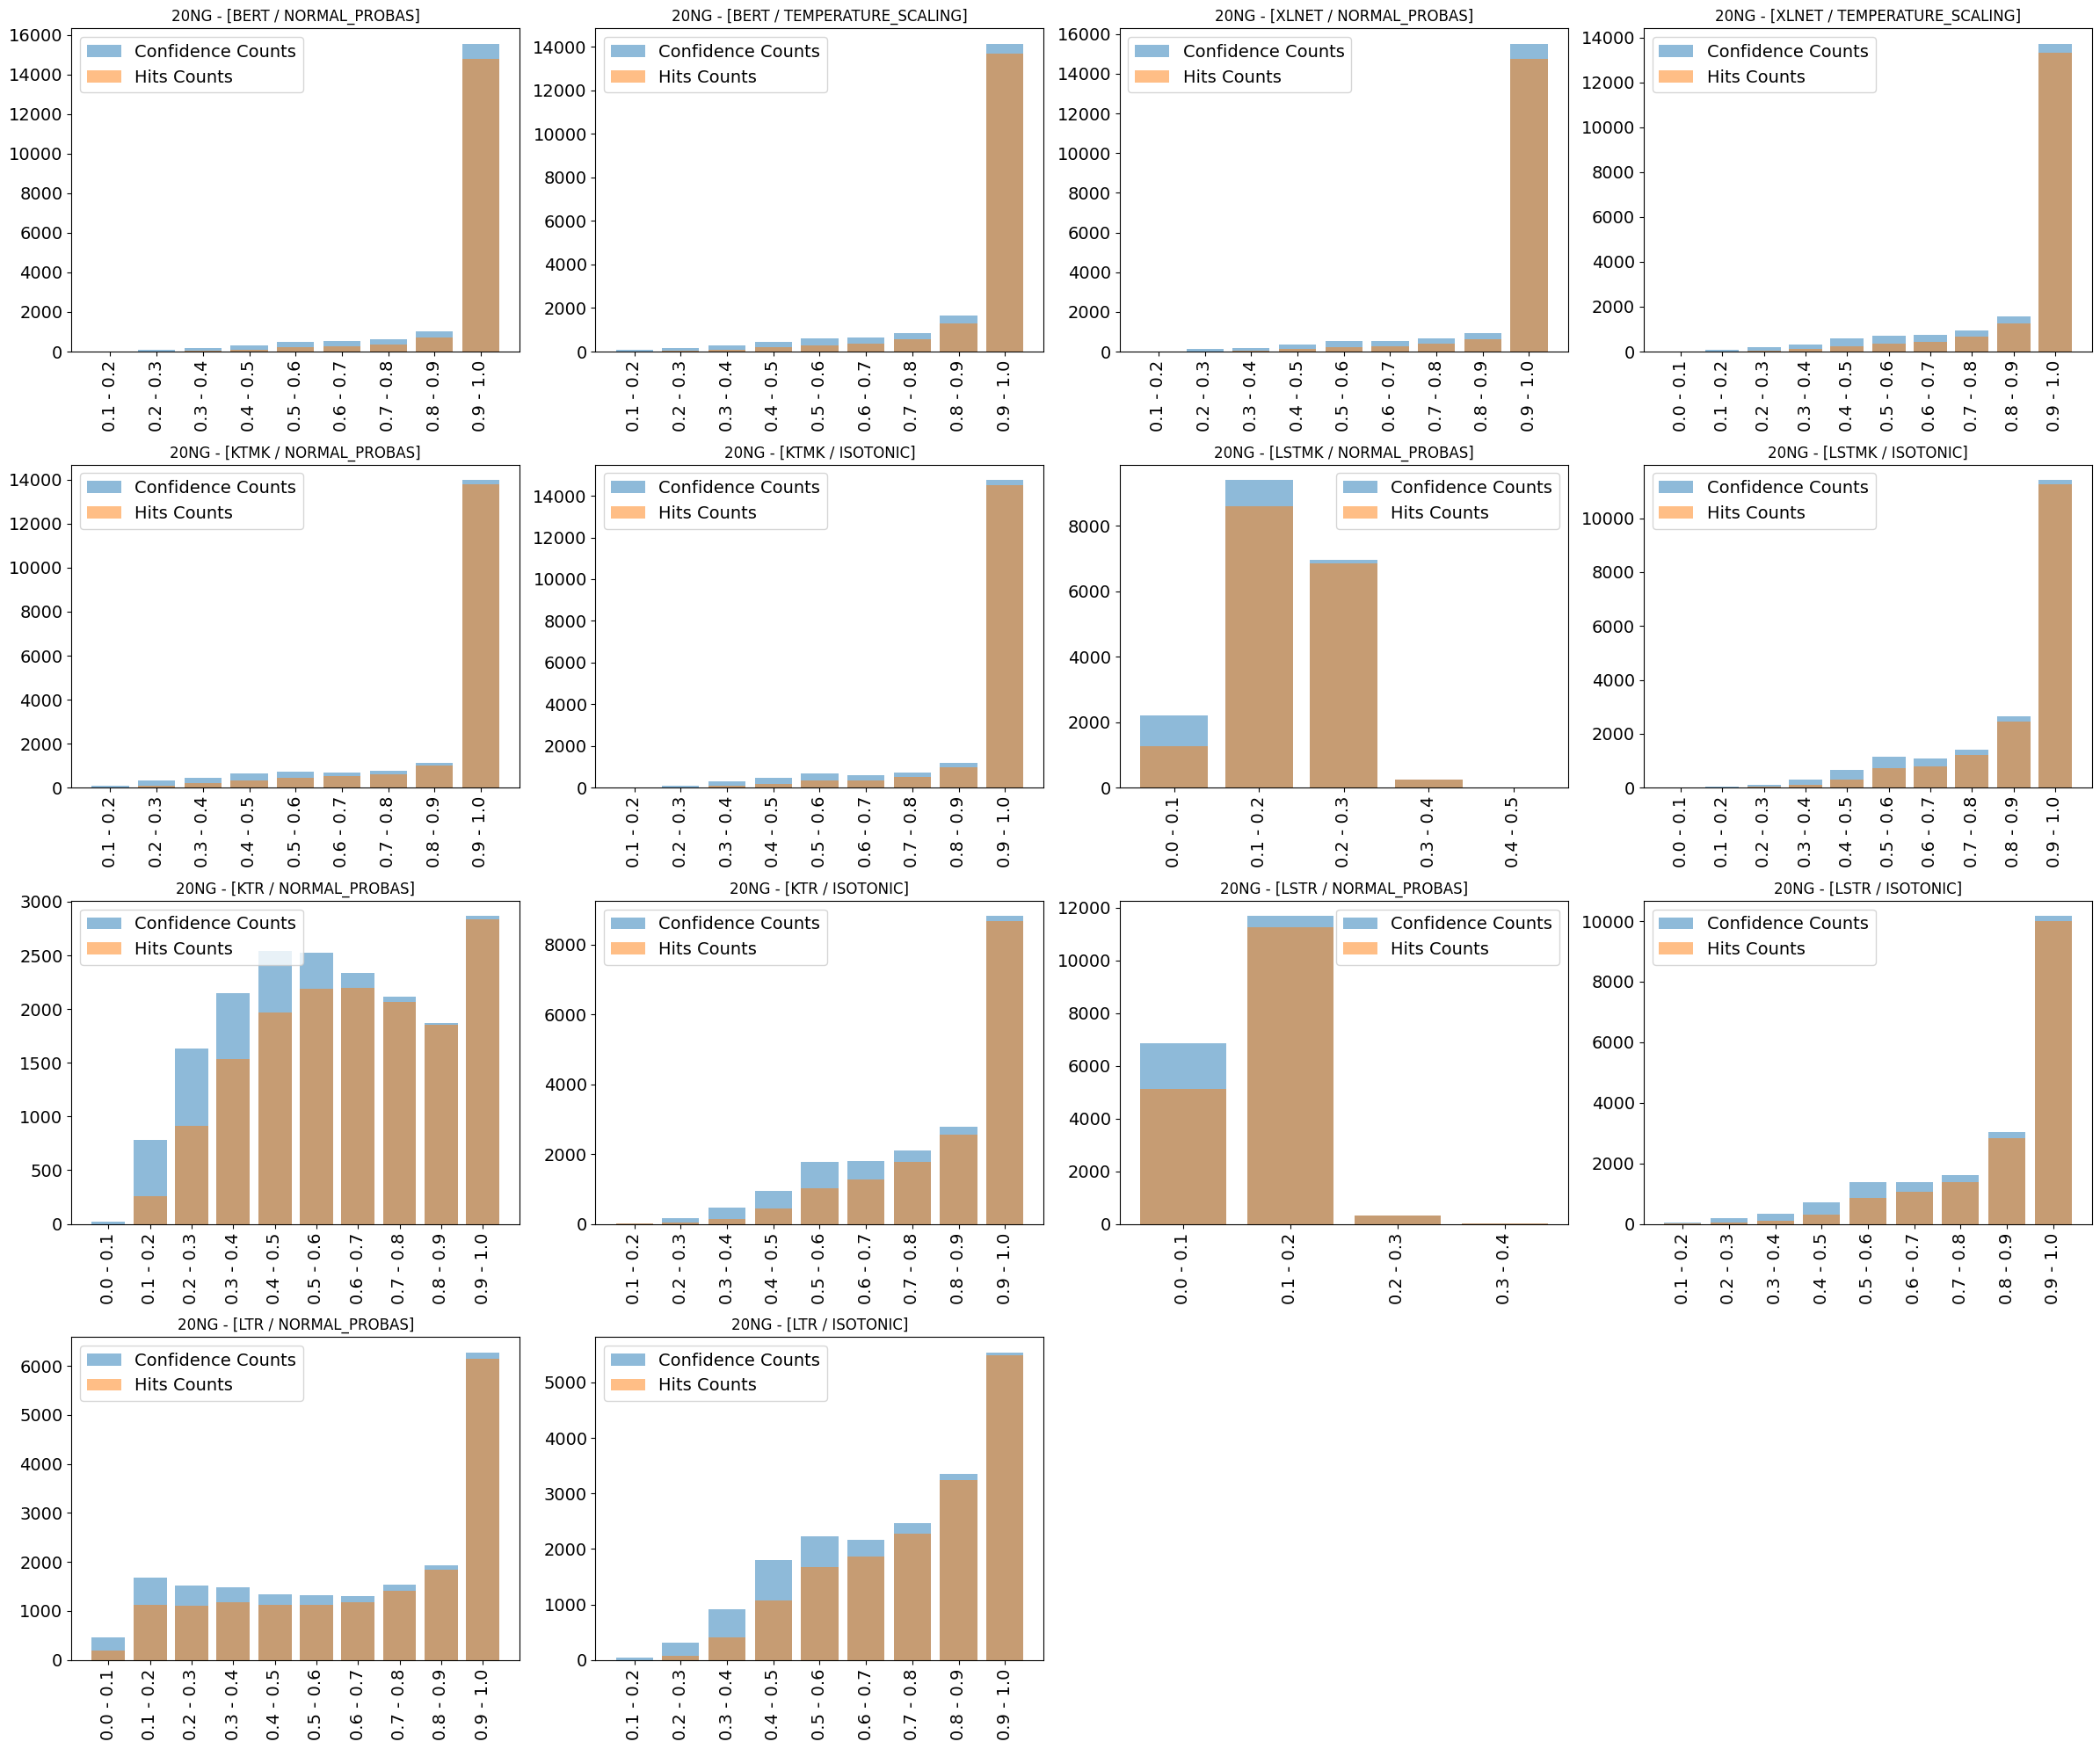

In [45]:
plotter(["20ng"], MIX_SET, [normal_probas, calib_probas], pd_datasets)

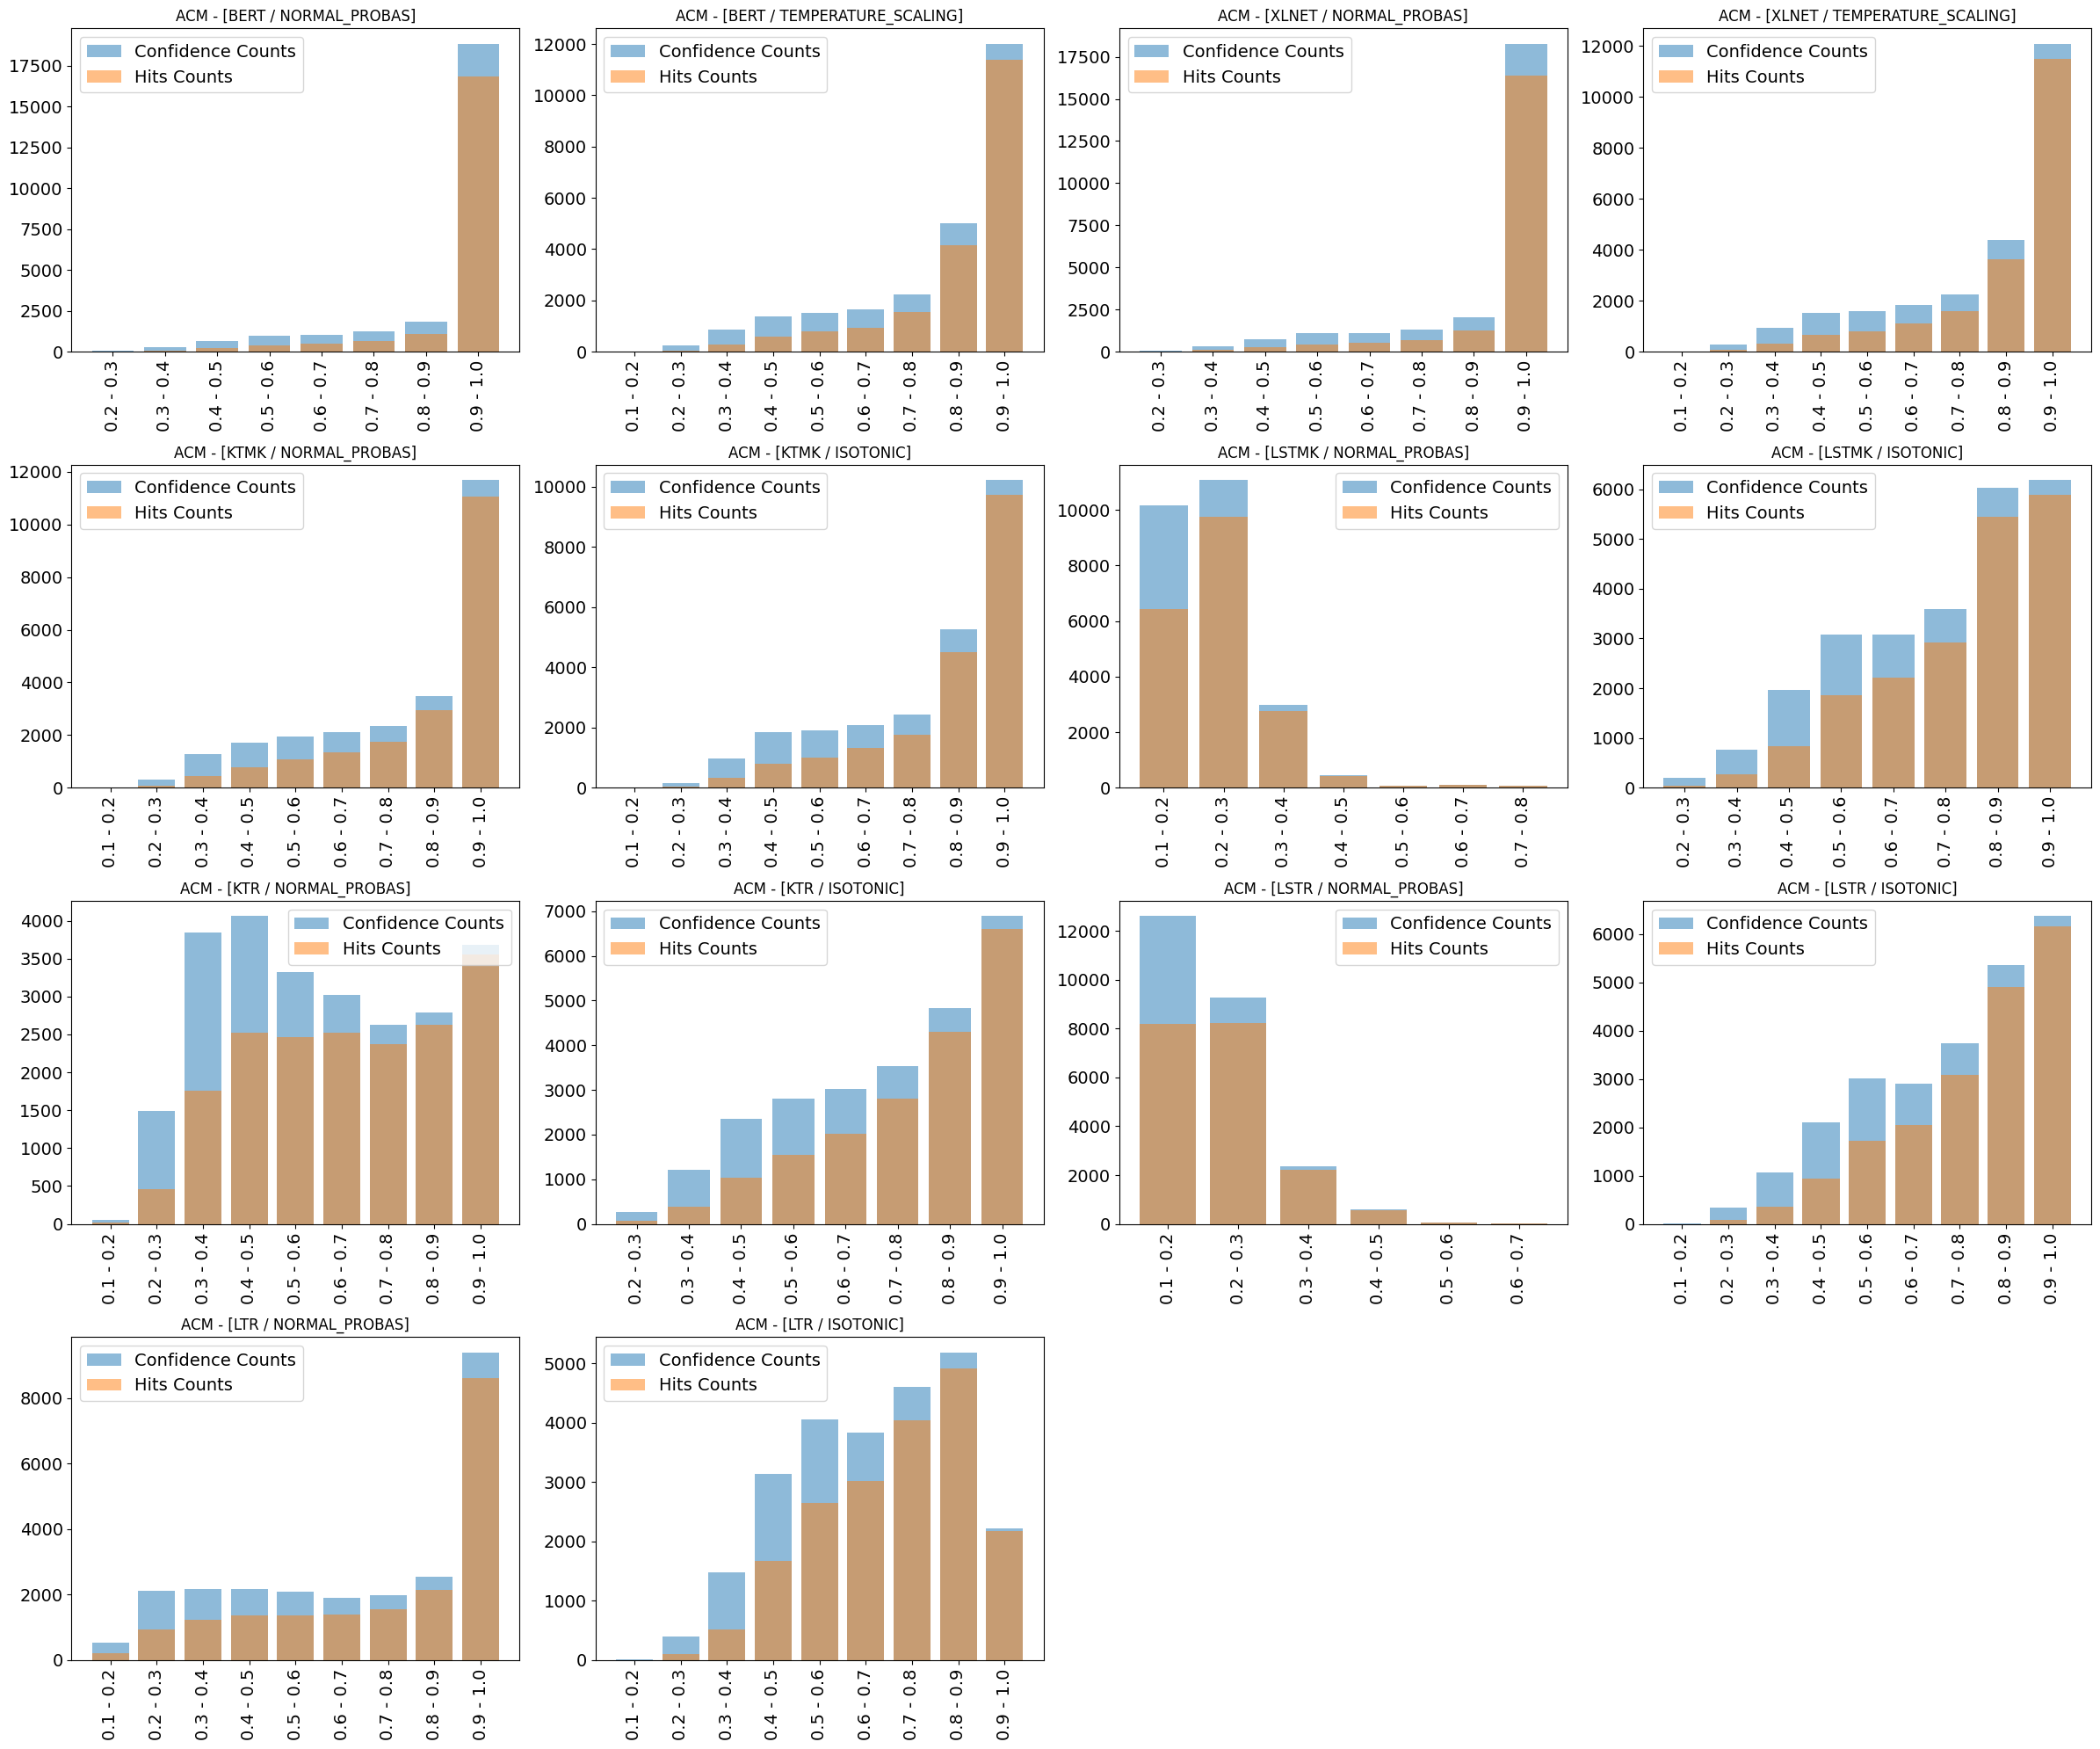

In [46]:
plotter(["acm"], MIX_SET, [normal_probas, calib_probas], pd_datasets)